# Méthode de détection

In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

from clib.flow import *
from clib.bellhop import *
import subprocess
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

### Profils de Méditerrannée

In [574]:
s = bellhop({'mediterrannee': '../SSP_4profils.mat'},name='profiles')

In [3]:
c_med = s.SSP['mediterrannee']['c'][:,::10]
depth_med = s.SSP['mediterrannee']['depth'][::10]

### Profils Gulf Stream

In [4]:
g1 = bellhop({'gs': {'datadir': '/home/datawork-lops-osi/jgula/NESED/', 'lon': -61.2, \
                    'lat': 42., 'plot_map': False, 'contour':False}}, zmax = 4900)

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.123, max=-58.273
lat_rho min= 34.123, max=43.734
h min= 20.000, max=5543.070
Uses the following output file: /home/datawork-lops-osi/jgula/NESED/nesed_avg.00060.nc


In [5]:
g2 = bellhop({'gs': {'datadir': '/home/datawork-lops-osi/jgula/NESED/', 'lon': -66.6, \
                    'lat': 36., 'plot_map': False, 'contour': False}}, zmax = 4900)

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.123, max=-58.273
lat_rho min= 34.123, max=43.734
h min= 20.000, max=5543.070
Uses the following output file: /home/datawork-lops-osi/jgula/NESED/nesed_avg.00060.nc


In [6]:
c_gs = np.vstack((g1.SSP['gs']['c'], g2.SSP['gs']['c']))
depth_gs = np.vstack((g1.SSP['gs']['depth'], g2.SSP['gs']['depth']))

---
---
## Exemple du travail à faire sur un 1er profil

In [7]:
### Creat .env file

issp=0                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]
s.params['NDepth'] = 6
s.params['NRange'] = 11
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med1.env' )


In [8]:
### read file .arr 
Arr1, Pos1 = s.read_arrivals_asc ('files/med1.arr', Narrmx = 2785)

Max.number of arrivals for source index 0 is 2783


In [9]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos1['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos1['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  20


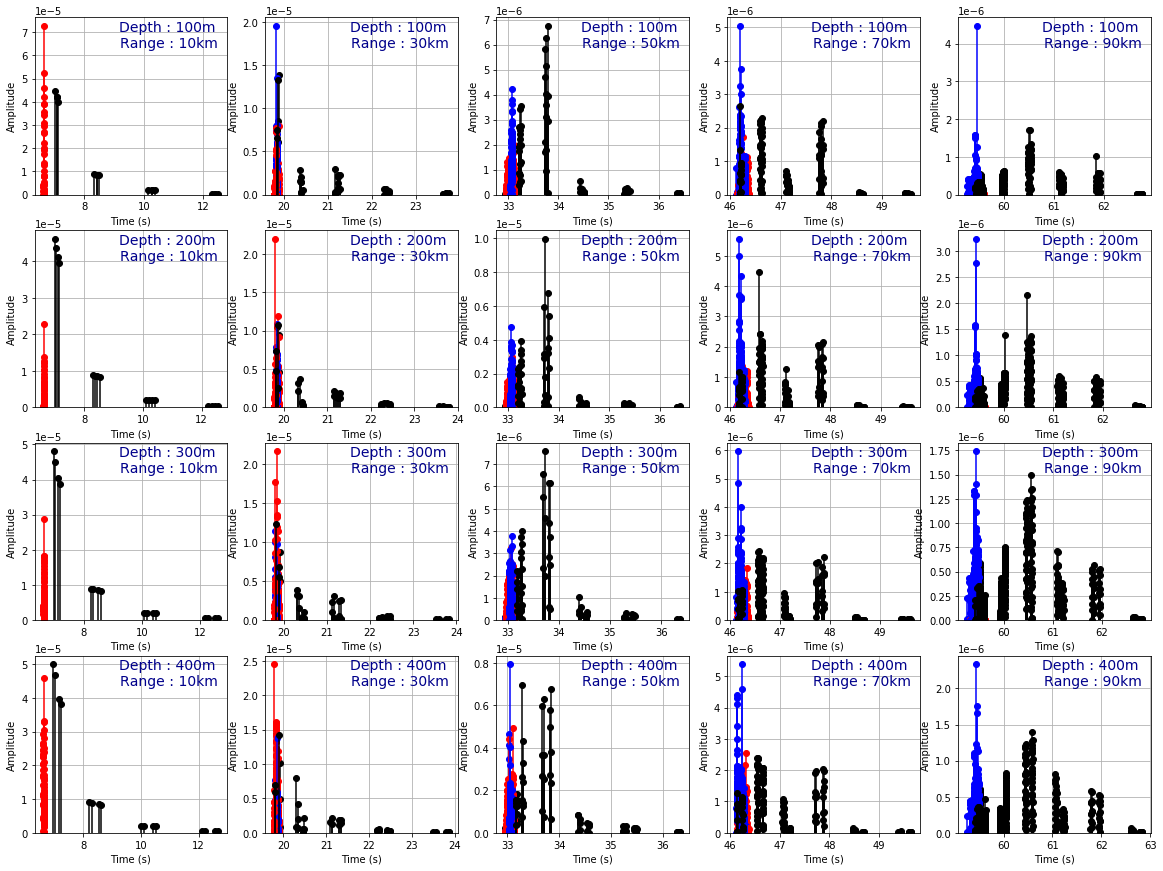

In [10]:
isd = 0       # choice of source depth

Total_time = []
Amp_min = []

plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        s.plotarr(Arr1, Pos1, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()
        
        Narr = int(Arr1['Narr'][irr,ird,isd])
        amp = Arr1['A'][irr,:Narr, ird, isd]
        Amp_min.append(np.min(abs(amp)))
        times = Arr1['delay'][irr, :Narr, ird, isd]
        Total_time.append(np.max(times)-np.min(times))

### ZOOM 

In [11]:
# sonar equation
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)
B = 200                  # bandwidth (Hz)
T = 1                    # transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

# SL - TL - NL + DI + PG  >  RL 

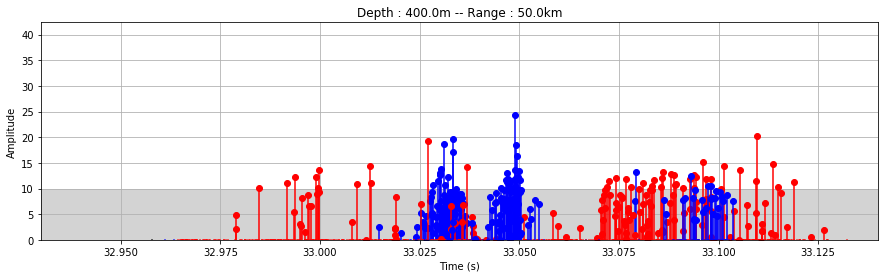

In [12]:
ird = 4       # depth : 300m    
irr = 5       # range : 50km  

plt.figure(figsize=(15,4))
ax = plt.subplot(111)
Narr = int(Arr1['Narr'][irr, ird, isd])
for i in range (Narr) : 
    t = Arr1['delay'][irr, i, ird, isd]
    TL = -20*np.log10 (abs(Arr1['A'][irr, i, ird, isd]))
    RL = SL - TL -NL +DI + PG
    markerline, stemlines, baseline = plt.stem( [t], [RL])            

    if np.logical_and ( Arr1['NumTopBnc'][irr, i,ird,isd] == 0, Arr1['NumBotBnc'][irr, i,ird,isd] == 0):
        plt.setp(stemlines, color = 'r')
        plt.setp(markerline, color = 'r')

    elif Arr1['NumBotBnc'][irr, i,ird,isd] == 0:
        plt.setp(stemlines, color = 'b')
        plt.setp(markerline, color = 'b')

    else : 
        plt.setp(stemlines, color = 'k')
        plt.setp(markerline, color = 'k')

plt.ylim(ymin=0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Source depth : %.1fm -- Receiver depth : %.1fm -- Receiver range : %.1fkm' \
#          % (Pos['s']['depth'][isd], Pos['r']['depth'][ird], Pos['r']['range'][irr]/1000.))
plt.title('Depth : %.1fm -- Range : %.1fkm' %(Pos1['r']['depth'][ird], Pos1['r']['range'][irr]/1000.))
plt.grid()
plt.xlim([32.93, 33.14])
#plt.xlim([33.025, 33.08])

ax.fill_between(np.array([0.,75.]), np.array([10., 10.]), facecolor='lightgrey')

---
## CHOIX de la méthode de détection : 1er rayon > 10 dB

In [13]:
isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr1['Narr'][irr,ird,isd])
        amp = Arr1['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr1['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        t_first = np.min(t_ok)
        idx_first = np.where(times==t_first)[0][0]
        
        # Chosen ray features
        NumTopBnc_f = Arr1['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
        NumBotBnc_f = Arr1['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
        SrcAngle_f  = Arr1['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
        # Appends
        TopBnc.append(NumTopBnc_f)
        BotBnc.append(NumBotBnc_f)
        SrcAngle.append(SrcAngle_f)
        Tarr.append(t_first)

In [14]:
n = R.size
print('SrcAngle : \n')
print ('                  10km          30km         50km         70km         90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :  %.5f°    %.5f°    %.5f°    %.5f°    %.5f°' %(D[i], SrcAngle[n*i], \
                                                                        SrcAngle[n*i+1], SrcAngle[n*i+2], \
                                                                        SrcAngle[n*i+3], SrcAngle[n*i+4]))

SrcAngle : 

                  10km          30km         50km         70km         90km

  Depth = 100m :  2.34520°    0.60505°    -6.07551°    -10.11584°    -8.04567°
  Depth = 200m :  2.03517°    -0.88507°    -1.80515°    -10.20585°    -8.03567°
  Depth = 300m :  0.48504°    -0.73506°    0.88507°    -10.19585°    8.41570°
  Depth = 400m :  -1.33511°    -0.73506°    -0.99508°    10.84590°    8.70573°


In [15]:
k = True
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k = False
print ('Pas de réfélchis fond : %s.' %k)

Pas de réfélchis fond : True.


In [16]:
n = R.size
print('TopBnc : \n')
print ('                 10km     30km     50km     70km     90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %d        %d        %d        %d        %d' %(D[i], TopBnc[n*i], \
                                                                        TopBnc[n*i+1], TopBnc[n*i+2], \
                                                                        TopBnc[n*i+3], TopBnc[n*i+4]))

TopBnc : 

                 10km     30km     50km     70km     90km

  Depth = 100m :   0        0        2        2        3
  Depth = 200m :   0        0        0        2        3
  Depth = 300m :   0        0        0        2        2
  Depth = 400m :   0        0        0        1        2


In [17]:
#ird = 2   # *100 = depth (m)
#irr = 9   # *10 = range (km)

Dist = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        

        # angle surlequel on travaille

        idx_d = np.where(D==ird*100.)[0][0]
        idx_r = np.where(R==irr*10.*1000.)[0][0]
        angle = SrcAngle[R.size*idx_d + idx_r]

        ### Creat .env file E

        issp=0                          # sound speed profile number
        s.params['file_type'] = 'E'
        s.params['ALimites'] = [angle]

        s.params['zmin'] = Pos1['r']['depth'][ird]          # receiver depth (m)
        s.params['rmin'] = Pos1['r']['range'][irr]/1000.    # receiver range (km)  

        s.params['NDepth'] = 1
        s.params['NRange'] = 1
        s.params['NBeams'] = 2

        s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med1_E.env' )
        
        ### execute bellhop
        subprocess.call(["bellhop.exe", 'med1_E'])
        
        ### output .ray file
        dictE = s.plotE ('med1_E.ray', plot = False)
        angles_E = dictE['SrcAngle']
        

        ### distance correspondante  
        if angles_E.size == 1 : 
            dist = dictE['Dist'][0]
        else :
            dist = dictE['Dist'][np.where(angles_E !=0.)][0]
        
        Dist.append(dist)


In [18]:
n = R.size
print('Distance : \n')
print ('                   10km      30km       50km      70km      90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %d     %d      %d     %d     %d' %(D[i], Dist[n*i], \
                                                                        Dist[n*i+1], Dist[n*i+2], \
                                                                        Dist[n*i+3], Dist[n*i+4]))

Distance : 

                   10km      30km       50km      70km      90km

  Depth = 100m :   10009     30044      50112     70407     90357
  Depth = 200m :   10011     30042      50057     70419     90354
  Depth = 300m :   10014     30046      50072     70412     90347
  Depth = 400m :   10010     30046      50068     70436     90366


---
## Régressions linéaires

In [19]:
### On connaît le temps d'arrivée et le range correspondant pour les 20 vignettes
TT = np.array(Tarr)
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [20]:
### 1 seule régression linéaire 
res = np.polyfit(TT, REAL_RANGE,1)
Rreg = res[0] * TT + res[1]
Diff1 = REAL_RANGE - Rreg

In [21]:
### 2 régressions linéaires correspondant aux deux catégories de rayons (avant et après 60km)
idx1 = np.where(REAL_RANGE < 60.*1000.)[0]
idx2 = np.where(REAL_RANGE >= 60.*1000.)[0]

res1 = np.polyfit(TT[idx1], REAL_RANGE[idx1],1)
res2 = np.polyfit(TT[idx2], REAL_RANGE[idx2],1)

Rreg_inf60 = res1[0] * TT[idx1] + res1[1]
Rreg_sup60 = res2[0] * TT[idx2] + res2[1]

diff_a = REAL_RANGE[idx1] - Rreg_inf60
diff_b = REAL_RANGE[idx2] - Rreg_sup60
Diff2 = np.hstack( (diff_a, diff_b) )

In [22]:
### Mean values 
print(np.mean(abs(Diff1)))
print(np.mean(abs(Diff2)))

33.1029759819191
19.734502930331928


In [23]:
### Max values 
print(np.max(abs(Diff1)))
print(np.max(abs(Diff2)))

76.36858010820288
71.87342131275363


In [ ]:
### Faire tableau avec les stats ... (min, max, mean, e_t, ...)

# Vérifications et stats avec plus de vignettes (19 x 9) ...

In [24]:
### Creat .env file

issp=0                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]

s.params['zmin'] = 0.
s.params['rmin'] = 0.
s.params['NDepth'] = 11
s.params['NRange'] = 21
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med1_complete.env' )

In [25]:
### read file .arr 
Arr2, Pos2 = s.read_arrivals_asc ('files/med1_complete.arr', Narrmx = 2786)

Max.number of arrivals for source index 0 is 2783


In [26]:
### Reponses impulsionnelles
D = np.arange(50., 450.+1., 50.)         # tous les 50m
R = np.arange(5., 95.+1., 5.)* 1000.     # tous les 5km
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  171


In [27]:
# 1er rayon supérieur à 10dB

isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr2['Narr'][irr,ird,isd])
        amp = Arr2['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr2['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        if len(t_ok) != 0 : 
            t_first = np.min(t_ok)
        
            idx_first = np.where(times==t_first)[0][0]
        
            # Chosen ray features
            NumTopBnc_f = Arr2['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
            NumBotBnc_f = Arr2['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
            SrcAngle_f  = Arr2['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
            # Appends
            TopBnc.append(NumTopBnc_f)
            BotBnc.append(NumBotBnc_f)
            SrcAngle.append(SrcAngle_f)
            Tarr.append(t_first)
            
        else : 
            TopBnc.append(np.NaN)
            BotBnc.append(np.NaN)
            SrcAngle.append(np.NaN)
            Tarr.append(np.NaN)
            

In [28]:
k = 0
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k += 1
print ('Nombre de réfélchis fond : %d/%d.' %(k, len(BotBnc)))

Nombre de réfélchis fond : 4/171.


In [29]:
Dist = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        

        # angle surlequel on travaille

        idx_d = np.where(D==ird*50.)[0][0]
        idx_r = np.where(R==irr*5.*1000.)[0][0]
        angle = SrcAngle[R.size*idx_d + idx_r]

        ### Creat .env file E

        issp=0                          # sound speed profile number
        s.params['file_type'] = 'E'
        s.params['ALimites'] = [angle]

        s.params['zmin'] = Pos2['r']['depth'][ird]          # receiver depth (m)
        s.params['rmin'] = Pos2['r']['range'][irr]/1000.    # receiver range (km)  

        s.params['NDepth'] = 1
        s.params['NRange'] = 1
        s.params['NBeams'] = 2

        s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med1_E.env' )
        
        ### execute bellhop
        subprocess.call(["bellhop.exe", 'med1_E'])
        
        ### output .ray file
        dictE = s.plotE ('med1_E.ray', plot = False)
        angles_E = dictE['SrcAngle']
        

        ### distance correspondante  
        if angles_E.size == 1 : 
            dist = dictE['Dist'][0]
        
        elif angles_E.size ==2 :
            dist = dictE['Dist'][np.where(angles_E !=0.)][0]
        
        else :
            dist = np.NaN
        
        Dist.append(dist)
        
Dist = np.array(Dist)

---
### Avec la régression linéaire précédente

In [30]:
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [33]:
### 2 régressions linéaires correspondant aux deux catégories de rayons (avant et après 60km)
Time = np.array(Tarr)

idx1tot = np.where(REAL_RANGE < 60.*1000.)[0]
idx2tot = np.where(REAL_RANGE >= 60.*1000.)[0]

Rtot_inf60 = res1[0] * Time[idx1tot] + res1[1]
Rtot_sup60 = res2[0] * Time[idx2tot] + res2[1]


diff_a = REAL_RANGE[idx1tot] - Rtot_inf60
diff_b = REAL_RANGE[idx2tot] - Rtot_sup60
Diff_tot = np.hstack( (diff_a, diff_b) )

In [34]:
np.max(abs(Diff_tot))

459.9024510351592

In [35]:
e_t = np.sqrt( np.mean( (Diff_tot)**2 ) )
e_t

74.85961238673151

---
### En une seule partie 

In [37]:
Rtot = res[0] * Time + res[1]
Diff_tot1 = REAL_RANGE - Rtot

In [38]:
np.max(abs(Diff_tot1))

454.4089689505345

In [39]:
e_t = np.sqrt( np.mean( (Diff_tot1)**2 ) )
e_t

70.14404980188772

In [42]:
sort = sorted(abs(Diff_tot1))

In [46]:
### on a 4 réfléchis fond qui introduisent de grandes erreurs
e_t = np.sqrt( np.mean( (np.array(sort[:-4]))**2 ) )
e_t

43.51921601838677

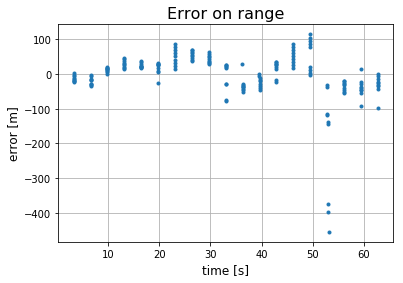

In [63]:
### error on range : real range - range from linear regression
plt.figure()
plt.plot(Time, Diff_tot1, '.')
plt.title('Error on range',fontsize=16)
plt.xlabel('time [s]',fontsize=12)
plt.ylabel('error [m]',fontsize=12)
plt.grid()

---
---
# Profil 2 

In [56]:
### Creat .env file

issp=1                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]

s.params['zmin'] = 0.
s.params['rmin'] = 0.
s.params['NDepth'] = 6
s.params['NRange'] = 11
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med2.env' )

In [59]:
### read file .arr 
Arr_prof2, Pos_prof2 = s.read_arrivals_asc ('files/med2.arr', Narrmx = 340)

Max.number of arrivals for source index 0 is 339


In [241]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos_prof2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos_prof2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  20


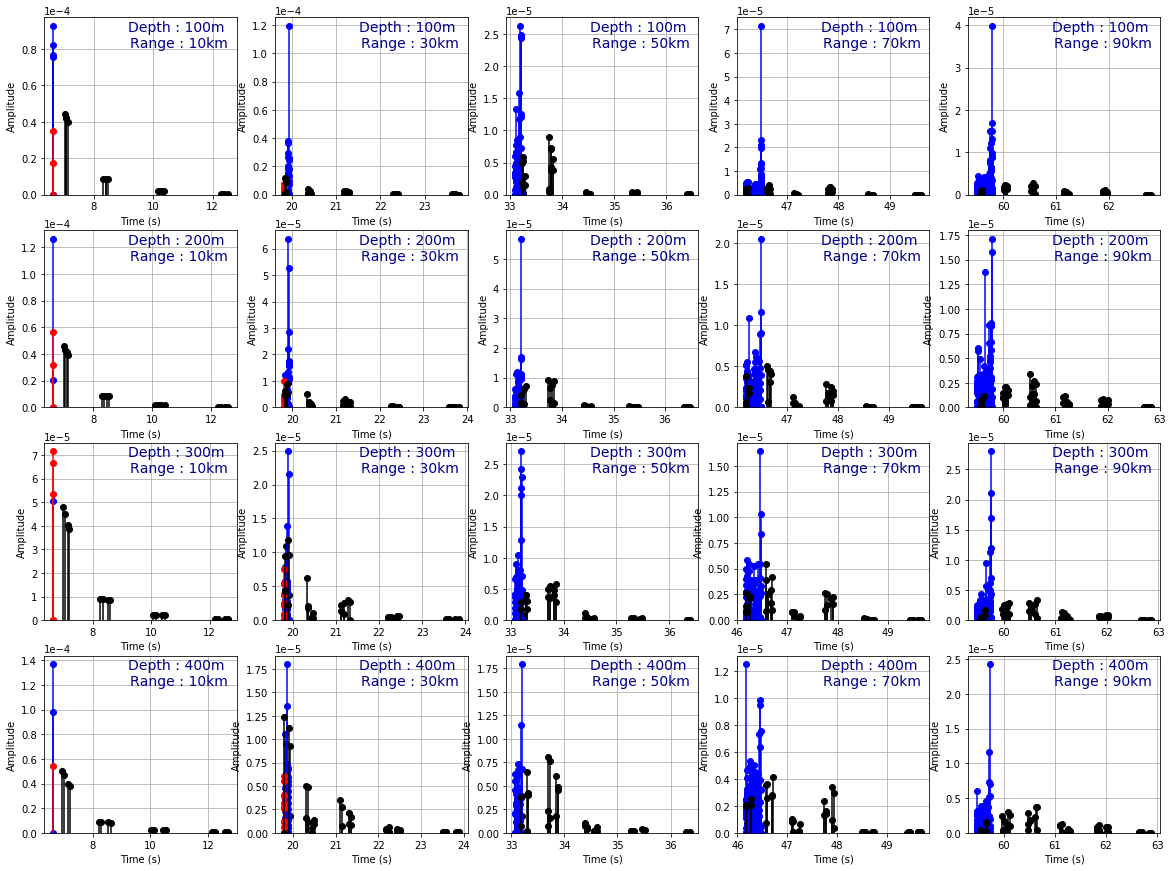

In [64]:
isd = 0       # choice of source depth

Total_time = []
Amp_min = []

plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        s.plotarr(Arr_prof2, Pos_prof2, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()
        
        Narr = int(Arr_prof2['Narr'][irr,ird,isd])
        amp = Arr_prof2['A'][irr,:Narr, ird, isd]
        Amp_min.append(np.min(abs(amp)))
        times = Arr_prof2['delay'][irr, :Narr, ird, isd]
        Total_time.append(np.max(times)-np.min(times))

### Zoom

In [65]:
# sonar equation
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)
B = 200                  # bandwidth (Hz)
T = 1                    # transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

# SL - TL - NL + DI + PG  >  RL 

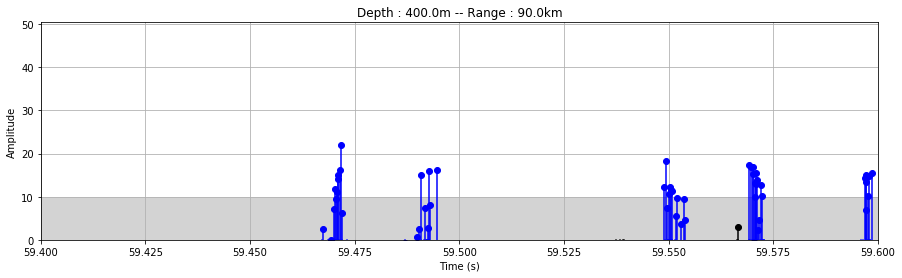

In [361]:
ird = 4       # depth : 300m    
irr = 9       # range : 50km  

plt.figure(figsize=(15,4))
ax = plt.subplot(111)
Narr = int(Arr_prof2['Narr'][irr, ird, isd])
for i in range (Narr) : 
    t = Arr_prof2['delay'][irr, i, ird, isd]
    TL = -20*np.log10 (abs(Arr_prof2['A'][irr, i, ird, isd]))
    RL = SL - TL -NL +DI + PG
    markerline, stemlines, baseline = plt.stem( [t], [RL])            

    if np.logical_and ( Arr_prof2['NumTopBnc'][irr, i,ird,isd] == 0, Arr_prof2['NumBotBnc'][irr, i,ird,isd] == 0):
        plt.setp(stemlines, color = 'r')
        plt.setp(markerline, color = 'r')

    elif Arr_prof2['NumBotBnc'][irr, i,ird,isd] == 0:
        plt.setp(stemlines, color = 'b')
        plt.setp(markerline, color = 'b')

    else : 
        plt.setp(stemlines, color = 'k')
        plt.setp(markerline, color = 'k')

plt.ylim(ymin=0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Source depth : %.1fm -- Receiver depth : %.1fm -- Receiver range : %.1fkm' \
#          % (Pos['s']['depth'][isd], Pos['r']['depth'][ird], Pos['r']['range'][irr]/1000.))
plt.title('Depth : %.1fm -- Range : %.1fkm' %(Pos_prof2['r']['depth'][ird], Pos_prof2['r']['range'][irr]/1000.))
plt.grid()
#plt.xlim([6., 8.])
#plt.xlim([33., 33.9])
plt.xlim([59.4,59.6])

ax.fill_between(np.array([0.,75.]), np.array([10., 10.]), facecolor='lightgrey')

## CHOIX de la méthode de détection : 1er rayon > 10dB

In [321]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90., 100.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos_prof2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos_prof2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  24


In [322]:
isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr_prof2['Narr'][irr,ird,isd])
        amp = Arr_prof2['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr_prof2['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        t_first = np.min(t_ok)
        idx_first = np.where(times==t_first)[0][0]

        
        # Chosen ray features
        NumTopBnc_f = Arr_prof2['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
        NumBotBnc_f = Arr_prof2['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
        SrcAngle_f  = Arr_prof2['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
        # Appends
        TopBnc.append(NumTopBnc_f)
        BotBnc.append(NumBotBnc_f)
        SrcAngle.append(SrcAngle_f)
        Tarr.append(t_first)

In [323]:
k = True
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k = False
print ('Pas de réfélchis fond : %s.' %k)

Pas de réfélchis fond : True.


In [324]:
n = R.size
print('TopBnc : \n')
print ('                 10km     30km     50km     70km     90km    100km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %d        %d        %d        %d        %d       %d' %(D[i], TopBnc[n*i], \
                                                                        TopBnc[n*i+1], TopBnc[n*i+2], \
                                                                TopBnc[n*i+3], TopBnc[n*i+4], TopBnc[n*i+5]))

TopBnc : 

                 10km     30km     50km     70km     90km    100km

  Depth = 100m :   0        0        1        1        2       2
  Depth = 200m :   0        0        1        1        2       2
  Depth = 300m :   0        0        1        1        2       2
  Depth = 400m :   0        0        1        1        2       2


In [325]:
### On connaît le temps d'arrivée et le range correspondant pour les 20 vignettes
TT = np.array(Tarr)
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [326]:
### 1 seule régression linéaire 
res = np.polyfit(TT, REAL_RANGE,1)
Rreg = res[0] * TT + res[1]
Diff1 = REAL_RANGE - Rreg

In [327]:
### Mean values 
print(np.mean(abs(Diff1)))

48.42229179208349


In [328]:
e_t = np.sqrt( np.mean( (Diff1)**2 ) )
e_t

57.222648934398435

In [329]:
### 3 régressions linéaires correspondant aux trois catégories de rayons
idx1 = np.where(REAL_RANGE < 40.*1000.)[0]
idx2 = np.where(np.logical_and(REAL_RANGE >= 40.*1000., REAL_RANGE < 80.*1000.) )[0]
idx3 = np.where(REAL_RANGE >= 80.*1000.)[0]

res1 = np.polyfit(TT[idx1], REAL_RANGE[idx1],1)
res2 = np.polyfit(TT[idx2], REAL_RANGE[idx2],1)
res3 = np.polyfit(TT[idx3], REAL_RANGE[idx3],1)

Rreg_inf40 = res1[0] * TT[idx1] + res1[1]
Rreg_inf80 = res2[0] * TT[idx2] + res2[1]
Rreg_sup80 = res3[0] * TT[idx3] + res3[1]


diff_a = REAL_RANGE[idx1] - Rreg_inf40
diff_b = REAL_RANGE[idx2] - Rreg_inf80
diff_c = REAL_RANGE[idx3] - Rreg_sup80

Diff2 = np.hstack( (diff_a, diff_b, diff_c) )

In [330]:
### Mean values 
print(np.max(abs(Diff2)))

27.087310114045977


In [331]:
e_t = np.sqrt( np.mean( (Diff2)**2 ) )
e_t

16.21287728479281

---
## Vérifications avec plus de vignettes

In [332]:
### Creat .env file

issp=1                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]

s.params['zmin'] = 0.
s.params['rmin'] = 0.
s.params['NDepth'] = 11
s.params['NRange'] = 21
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med2_complete.env' )

In [333]:
### read file .arr 
Arr2_prof2, Pos2_prof2 = s.read_arrivals_asc ('files/med2_complete.arr', Narrmx = 340)

Max.number of arrivals for source index 0 is 339


In [334]:
### Reponses impulsionnelles
D = np.arange(50., 450.+1., 50.)         # tous les 50m
R = np.arange(5., 95.+1., 5.)* 1000.     # tous les 5km
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos2_prof2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos2_prof2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  171


In [335]:
# 1er rayon supérieur à 10dB

isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr2_prof2['Narr'][irr,ird,isd])
        amp = Arr2_prof2['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr2_prof2['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        if len(t_ok) != 0 : 
            t_first = np.min(t_ok)
        
            idx_first = np.where(times==t_first)[0][0]
        
            # Chosen ray features
            NumTopBnc_f = Arr2_prof2['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
            NumBotBnc_f = Arr2_prof2['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
            SrcAngle_f  = Arr2_prof2['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
            # Appends
            TopBnc.append(NumTopBnc_f)
            BotBnc.append(NumBotBnc_f)
            SrcAngle.append(SrcAngle_f)
            Tarr.append(t_first)
            
        else : 
            TopBnc.append(np.NaN)
            BotBnc.append(np.NaN)
            SrcAngle.append(np.NaN)
            Tarr.append(np.NaN)

In [336]:
k = 0
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k += 1
print ('Nombre de réfélchis fond : %d/%d.' %(k, len(BotBnc)))

Nombre de réfélchis fond : 0/171.


#### Avec la régression linéaire précédente

In [337]:
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [338]:
### 3 régressions linéaires correspondant aux trois catégories de rayons

Time = np.array(Tarr)

idx1tot = np.where(REAL_RANGE < 40.*1000.)[0]
idx2tot = np.where(np.logical_and(REAL_RANGE >= 40.*1000., REAL_RANGE < 80.*1000.) )[0]
idx3tot = np.where(REAL_RANGE >= 80.*1000.)[0]


Rtot_inf40 = res1[0] * Time[idx1tot] + res1[1]
Rtot_inf80 = res2[0] * Time[idx2tot] + res2[1]
Rtot_sup80 = res3[0] * Time[idx3tot] + res3[1]


diff_a = REAL_RANGE[idx1tot] - Rtot_inf40
diff_b = REAL_RANGE[idx2tot] - Rtot_inf80
diff_c = REAL_RANGE[idx3tot] - Rtot_sup80

Diff2_tot = np.hstack( (diff_a, diff_b, diff_c) )

In [339]:
### Max value 
print(np.max(abs(Diff2_tot)))

257.6724446740991


In [340]:
e_t = np.sqrt( np.mean( (Diff2_tot)**2 ) )
e_t

67.54225380326999

In [351]:
### avec une unique régression 
RRR = res[0]*Time + res[1]
ddd = REAL_RANGE - RRR

In [352]:
e_t = np.sqrt( np.mean( (ddd)**2 ) )
e_t

69.87237848012677

In [353]:
print(np.max(abs(ddd)))

188.36418651133135


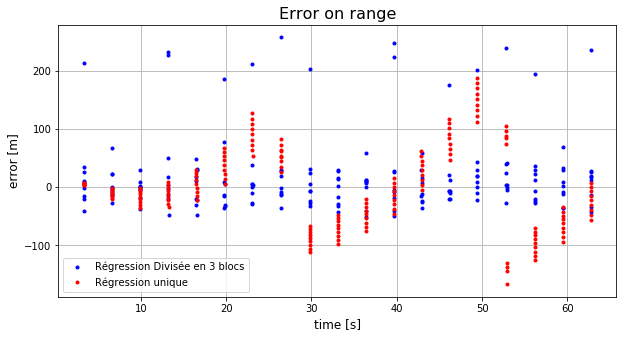

In [357]:
### error on range : real range - range from linear regression
plt.figure(figsize=(10,5))
plt.plot(Time, Diff2_tot, 'b.', label='Régression Divisée en 3 blocs')
plt.plot(Time, ddd, 'r.', label = 'Régression unique')
plt.title('Error on range',fontsize=16)
plt.xlabel('time [s]',fontsize=12)
plt.ylabel('error [m]',fontsize=12)
plt.grid()
plt.legend()

In [ ]:
### Tableau avec stats : ecart type, mmin, max, mean, ... 


----
---
# Profil N°3 

In [363]:
### Creat .env file

issp=2                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]

s.params['zmin'] = 0.
s.params['rmin'] = 0.
s.params['NDepth'] = 6
s.params['NRange'] = 11
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med3.env' )

In [365]:
### read file .arr 
Arr_prof3, Pos_prof3 = s.read_arrivals_asc ('files/med3.arr', Narrmx = 3107)

Max.number of arrivals for source index 0 is 3106


In [366]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos_prof2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos_prof2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  20


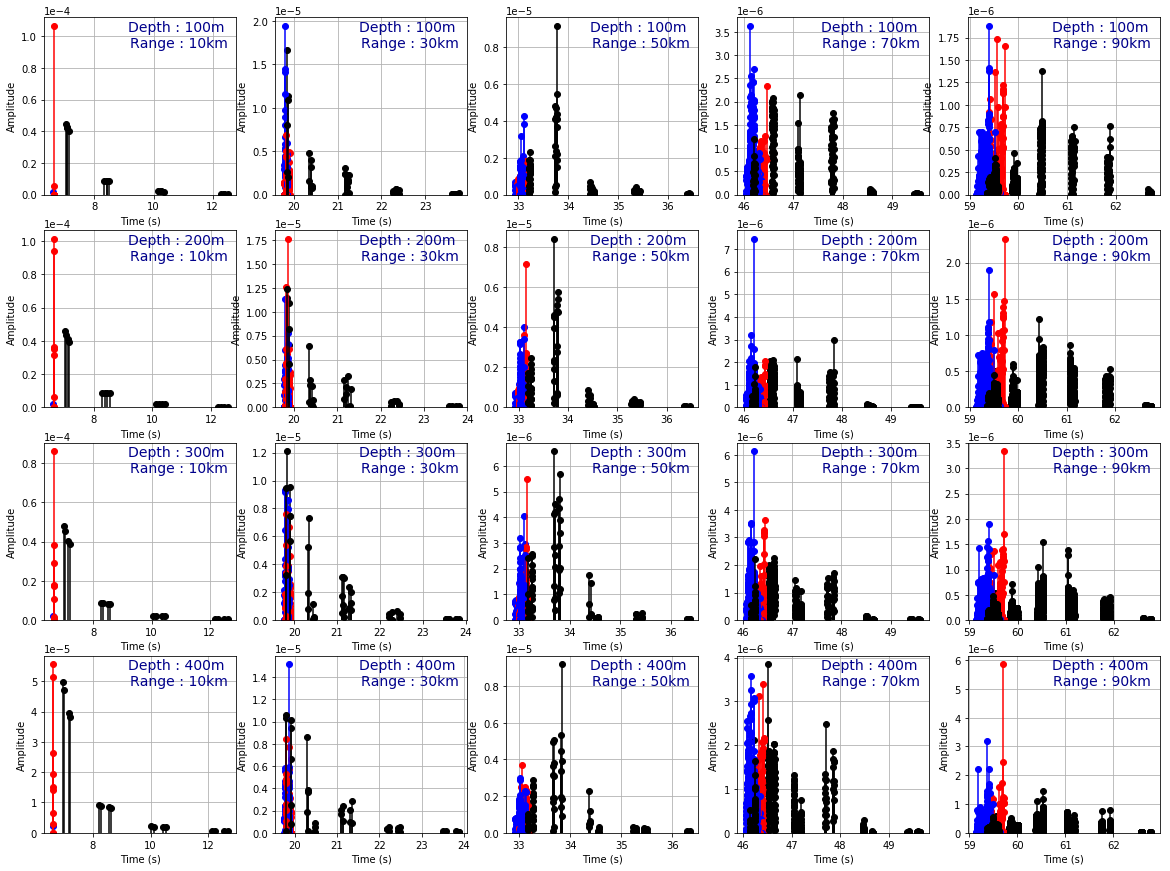

In [367]:
isd = 0       # choice of source depth

Total_time = []
Amp_min = []

plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        s.plotarr(Arr_prof3, Pos_prof3, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()
        
        Narr = int(Arr_prof3['Narr'][irr,ird,isd])
        amp = Arr_prof3['A'][irr,:Narr, ird, isd]
        Amp_min.append(np.min(abs(amp)))
        times = Arr_prof3['delay'][irr, :Narr, ird, isd]
        Total_time.append(np.max(times)-np.min(times))

### Zoom

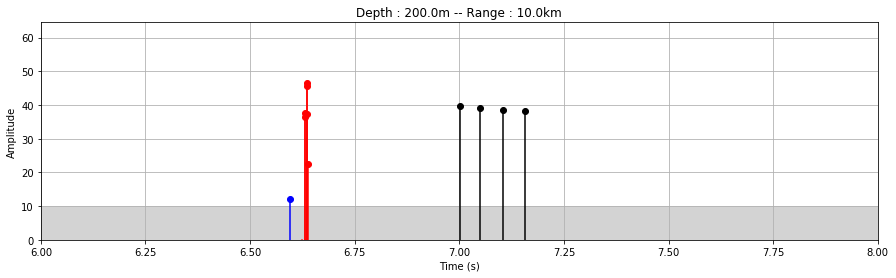

In [382]:
ird = 2       # depth : 300m    
irr = 1       # range : 50km  

plt.figure(figsize=(15,4))
ax = plt.subplot(111)
Narr = int(Arr_prof3['Narr'][irr, ird, isd])
for i in range (Narr) : 
    t = Arr_prof3['delay'][irr, i, ird, isd]
    TL = -20*np.log10 (abs(Arr_prof3['A'][irr, i, ird, isd]))
    RL = SL - TL -NL +DI + PG
    markerline, stemlines, baseline = plt.stem( [t], [RL])            

    if np.logical_and ( Arr_prof3['NumTopBnc'][irr, i,ird,isd] == 0, Arr_prof3['NumBotBnc'][irr, i,ird,isd] == 0):
        plt.setp(stemlines, color = 'r')
        plt.setp(markerline, color = 'r')

    elif Arr_prof3['NumBotBnc'][irr, i,ird,isd] == 0:
        plt.setp(stemlines, color = 'b')
        plt.setp(markerline, color = 'b')

    else : 
        plt.setp(stemlines, color = 'k')
        plt.setp(markerline, color = 'k')

plt.ylim(ymin=0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Source depth : %.1fm -- Receiver depth : %.1fm -- Receiver range : %.1fkm' \
#          % (Pos['s']['depth'][isd], Pos['r']['depth'][ird], Pos['r']['range'][irr]/1000.))
plt.title('Depth : %.1fm -- Range : %.1fkm' %(Pos_prof3['r']['depth'][ird], Pos_prof3['r']['range'][irr]/1000.))
plt.grid()
plt.xlim([6., 8.])
#plt.xlim([19.7,20.])
#plt.xlim([33., 33.9])
#plt.xlim([46.,55.])
#plt.xlim([59.4,59.6])

ax.fill_between(np.array([0.,75.]), np.array([10., 10.]), facecolor='lightgrey')

## CHOIX de la méthode de détection : 1er rayon > 10 dB

In [435]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 80., 90., 100.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos_prof2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos_prof2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  28


In [436]:
isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr_prof3['Narr'][irr,ird,isd])
        amp = Arr_prof3['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr_prof3['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        t_first = np.min(t_ok)
        idx_first = np.where(times==t_first)[0][0]

        
        # Chosen ray features
        NumTopBnc_f = Arr_prof3['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
        NumBotBnc_f = Arr_prof3['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
        SrcAngle_f  = Arr_prof3['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
        # Appends
        TopBnc.append(NumTopBnc_f)
        BotBnc.append(NumBotBnc_f)
        SrcAngle.append(SrcAngle_f)
        Tarr.append(t_first)

In [437]:
k = True
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k = False
print ('Pas de réfélchis fond : %s.' %k)

Pas de réfélchis fond : True.


In [438]:
n = R.size
print('TopBnc : \n')
print ('                 10km     30km     50km     70km    80km      90km     100km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %d        %d        %d        %d      %d        %d         %d' %(D[i], TopBnc[n*i], \
                                                                TopBnc[n*i+1], TopBnc[n*i+2], \
                                                                TopBnc[n*i+3], TopBnc[n*i+4], \
                                                                TopBnc[n*i+5], TopBnc[n*i+6]))

TopBnc : 

                 10km     30km     50km     70km    80km      90km     100km

  Depth = 100m :   1        1        1        2      2        3         2
  Depth = 200m :   1        1        1        2      2        3         2
  Depth = 300m :   1        1        1        2      2        3         3
  Depth = 400m :   1        1        1        2      0        3         3


In [439]:
#### On va donc faire 3 régressions linéaires ... 

In [440]:
### On connaît le temps d'arrivée et le range correspondant pour les 20 vignettes
TT = np.array(Tarr)
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [441]:
### 3 régressions linéaires correspondant aux trois catégories de rayons

idx1 = np.where(REAL_RANGE < 60.*1000.)[0]
idx2 = np.where(np.logical_and(REAL_RANGE >= 60.*1000., REAL_RANGE < 90.*1000.) )[0]
idx3 = np.where(REAL_RANGE >= 90.*1000.)[0]

res1 = np.polyfit(TT[idx1], REAL_RANGE[idx1],1)
res2 = np.polyfit(TT[idx2], REAL_RANGE[idx2],1)
res3 = np.polyfit(TT[idx3], REAL_RANGE[idx3],1)


Rreg_inf60 = res1[0] * TT[idx1] + res1[1]
Rreg_inf90 = res2[0] * TT[idx2] + res2[1]
Rreg_sup90 = res3[0] * TT[idx3] + res3[1]

diff_a = REAL_RANGE[idx1] - Rreg_inf60
diff_b = REAL_RANGE[idx2] - Rreg_inf90
diff_c = REAL_RANGE[idx3] - Rreg_sup90

Diff2 = np.hstack( (diff_a, diff_b, diff_c) )

In [442]:
e_t = np.sqrt( np.mean( (Diff2)**2 ) )
e_t

69.60007506894229

In [443]:
res = np.polyfit(TT, REAL_RANGE,1)
Rreg = res[0] * TT + res[1]
Diff = REAL_RANGE - Rreg

In [444]:
e_t = np.sqrt( np.mean( (Diff)**2 ) )
e_t

83.80782756245746

### Verif avec plus de vignettes

In [422]:
### Creat .env file

issp=1                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]

s.params['zmin'] = 0.
s.params['rmin'] = 0.
s.params['NDepth'] = 11
s.params['NRange'] = 21
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med3_complete.env' )

In [423]:
### read file .arr 
Arr2_prof3, Pos2_prof3 = s.read_arrivals_asc ('files/med3_complete.arr', Narrmx = 340)

Max.number of arrivals for source index 0 is 339


In [445]:
### Reponses impulsionnelles
D = np.arange(50., 450.+1., 50.)         # tous les 50m
R = np.arange(5., 95.+1., 5.)* 1000.     # tous les 5km
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos2_prof3['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos2_prof3['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  171


In [446]:
# 1er rayon supérieur à 10dB

isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr2_prof3['Narr'][irr,ird,isd])
        amp = Arr2_prof3['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr2_prof3['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        if len(t_ok) != 0 : 
            t_first = np.min(t_ok)
        
            idx_first = np.where(times==t_first)[0][0]
        
            # Chosen ray features
            NumTopBnc_f = Arr2_prof3['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
            NumBotBnc_f = Arr2_prof3['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
            SrcAngle_f  = Arr2_prof3['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
            # Appends
            TopBnc.append(NumTopBnc_f)
            BotBnc.append(NumBotBnc_f)
            SrcAngle.append(SrcAngle_f)
            Tarr.append(t_first)
            
        else : 
            TopBnc.append(np.NaN)
            BotBnc.append(np.NaN)
            SrcAngle.append(np.NaN)
            Tarr.append(np.NaN)

In [447]:
k = 0
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k += 1
print ('Nombre de réfélchis fond : %d/%d.' %(k, len(BotBnc)))

Nombre de réfélchis fond : 0/171.


In [448]:
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [449]:
Time = np.array(Tarr)

idx1tot = np.where(REAL_RANGE < 60.*1000.)[0]
idx2tot = np.where(np.logical_and(REAL_RANGE >= 60.*1000., REAL_RANGE < 90.*1000.) )[0]
idx3tot = np.where(REAL_RANGE >= 90.*1000.)[0]


Rtot_inf60 = res1[0] * Time[idx1tot] + res1[1]
Rtot_inf90 = res2[0] * Time[idx2tot] + res2[1]
Rtot_sup90 = res3[0] * Time[idx3tot] + res3[1]


diff_a = REAL_RANGE[idx1tot] - Rtot_inf60
diff_b = REAL_RANGE[idx2tot] - Rtot_inf90
diff_c = REAL_RANGE[idx3tot] - Rtot_sup90

Diff3_tot = np.hstack( (diff_a, diff_b, diff_c) )

In [450]:
e_t = np.sqrt( np.mean( (Diff3_tot)**2 ) )
e_t

139.59451383104417

In [452]:
Rtot = res[0] * Time + res[1]
Diff_tot = REAL_RANGE - Rtot

In [453]:
e_t = np.sqrt( np.mean( (Diff_tot)**2 ) )
e_t

134.85285608202258

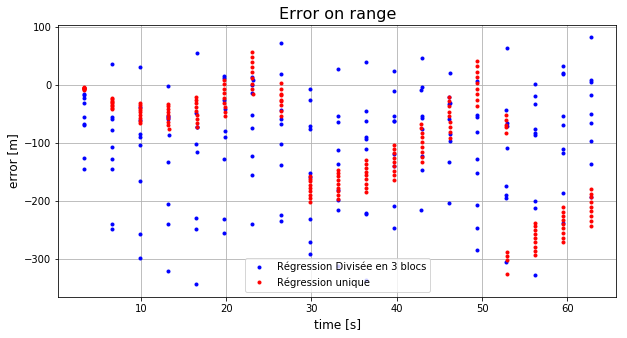

In [455]:
### error on range : real range - range from linear regression
plt.figure(figsize=(10,5))
plt.plot(Time, Diff3_tot, 'b.', label='Régression Divisée en 3 blocs')
plt.plot(Time, Diff_tot, 'r.', label='Régression unique')
plt.title('Error on range',fontsize=16)
plt.xlabel('time [s]',fontsize=12)
plt.ylabel('error [m]',fontsize=12)
plt.grid()
plt.legend()

In [ ]:
### Pas top, il faudrait trouver une autre méthode ...

# Profil n°4

In [456]:
### Creat .env file

issp=3                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]

s.params['zmin'] = 0.
s.params['rmin'] = 0.
s.params['NDepth'] = 6
s.params['NRange'] = 11
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med4.env' )

In [458]:
### read file .arr 
Arr_prof4, Pos_prof4 = s.read_arrivals_asc ('files/med4.arr', Narrmx = 4313)

Max.number of arrivals for source index 0 is 4312


In [508]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos_prof2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos_prof2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  20


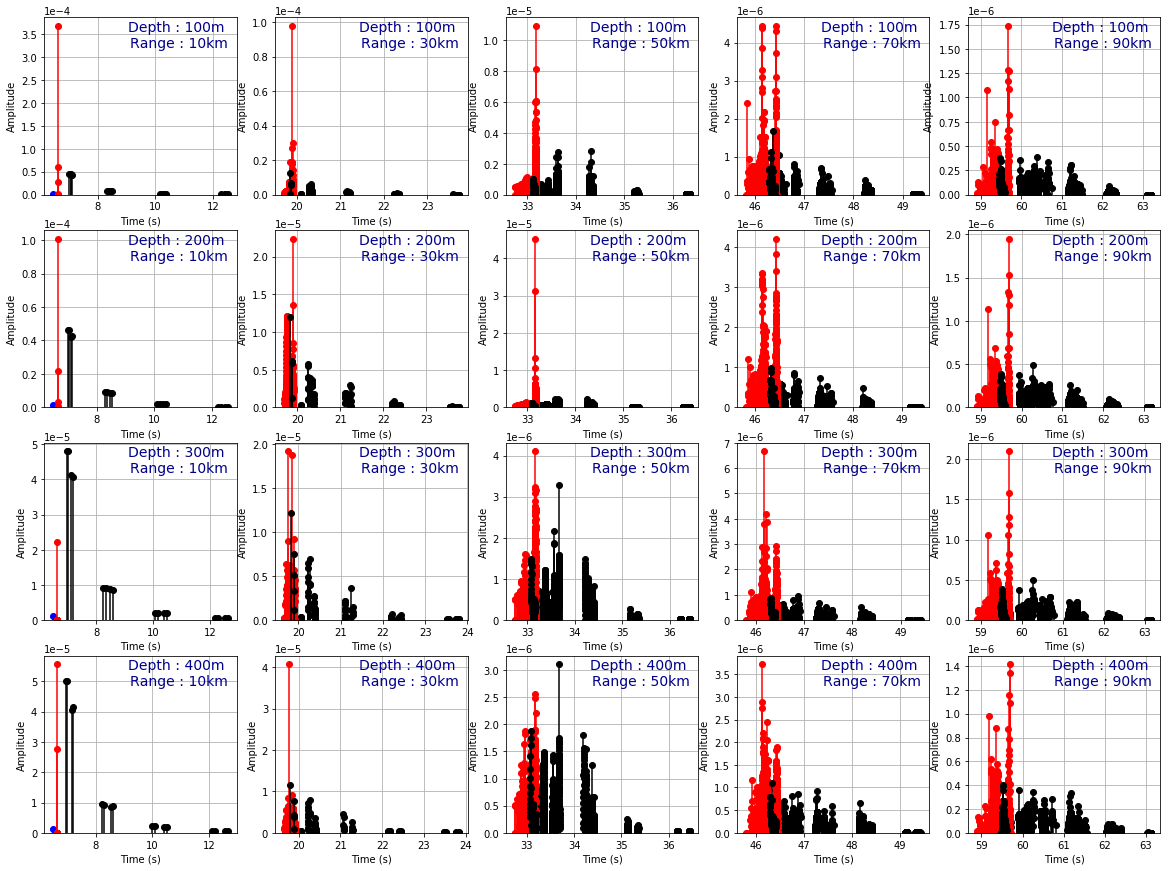

In [460]:
isd = 0       # choice of source depth

Total_time = []
Amp_min = []

plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        s.plotarr(Arr_prof4, Pos_prof4, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()
        
        Narr = int(Arr_prof4['Narr'][irr,ird,isd])
        amp = Arr_prof4['A'][irr,:Narr, ird, isd]
        Amp_min.append(np.min(abs(amp)))
        times = Arr_prof4['delay'][irr, :Narr, ird, isd]
        Total_time.append(np.max(times)-np.min(times))

### Zoom

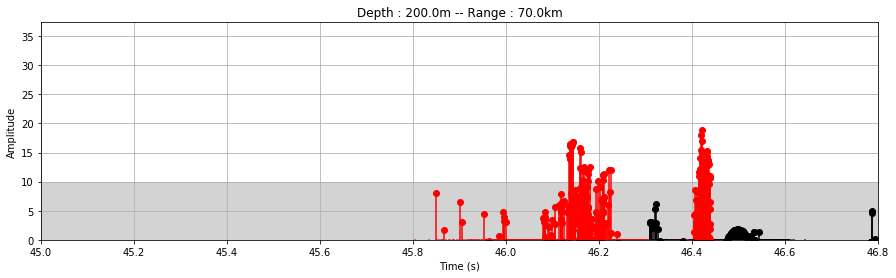

In [645]:
ird = 2       # depth : 300m    
irr = 7       # range : 50km  

plt.figure(figsize=(15,4))
ax = plt.subplot(111)
Narr = int(Arr_prof4['Narr'][irr, ird, isd])
for i in range (Narr) : 
    t = Arr_prof4['delay'][irr, i, ird, isd]
    TL = -20*np.log10 (abs(Arr_prof4['A'][irr, i, ird, isd]))
    RL = SL - TL -NL +DI + PG
    markerline, stemlines, baseline = plt.stem( [t], [RL])            

    if np.logical_and ( Arr_prof4['NumTopBnc'][irr, i,ird,isd] == 0, Arr_prof4['NumBotBnc'][irr, i,ird,isd] == 0):
        plt.setp(stemlines, color = 'r')
        plt.setp(markerline, color = 'r')

    elif Arr_prof4['NumBotBnc'][irr, i,ird,isd] == 0:
        plt.setp(stemlines, color = 'b')
        plt.setp(markerline, color = 'b')

    else : 
        plt.setp(stemlines, color = 'k')
        plt.setp(markerline, color = 'k')

plt.ylim(ymin=0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Source depth : %.1fm -- Receiver depth : %.1fm -- Receiver range : %.1fkm' \
#          % (Pos['s']['depth'][isd], Pos['r']['depth'][ird], Pos['r']['range'][irr]/1000.))
plt.title('Depth : %.1fm -- Range : %.1fkm' %(Pos_prof4['r']['depth'][ird], Pos_prof4['r']['range'][irr]/1000.))
plt.grid()
#plt.xlim([6., 7.5])
#plt.xlim([19.7,20.])
#plt.xlim([33., 33.9])
plt.xlim([45.,46.8])
#plt.xlim([59.4,59.6])

ax.fill_between(np.array([0.,75.]), np.array([10., 10.]), facecolor='lightgrey')

## Choix de la méthode de détection :  max d'amplitude

In [524]:
isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr_prof4['Narr'][irr,ird,isd])
        amp = Arr_prof4['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr_prof4['delay'][irr, :Narr, ird, isd]
        #idx = np.where(RL > 10.)
        #t_ok = times[idx]
        
        #if len(t_ok)>0 : 
            #t_first = np.min(t_ok)
            #idx_first = np.where(times==t_first)[0][0]
            

            # Chosen ray features
            #NumTopBnc_f = Arr_prof4['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
            #NumBotBnc_f = Arr_prof4['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
            #SrcAngle_f  = Arr_prof4['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
            # Appends
            #TopBnc.append(NumTopBnc_f)
            #BotBnc.append(NumBotBnc_f)
            #SrcAngle.append(SrcAngle_f)
            #Tarr.append(t_first) 
                
        #else : 
            #TopBnc.append(np.NaN)
            #BotBnc.append(np.NaN)
            #SrcAngle.append(np.NaN)
            #Tarr.append(np.NaN)
            
        
        idx_first = np.where(RL==np.max(RL))[0][0]
        
        NumTopBnc_f = Arr_prof4['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
        NumBotBnc_f = Arr_prof4['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
        SrcAngle_f  = Arr_prof4['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
        TopBnc.append(NumTopBnc_f)
        BotBnc.append(NumBotBnc_f)
        SrcAngle.append(SrcAngle_f)
        Tarr.append(times[idx_first])


In [525]:
k = 0
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k += 1
print ('Nombre de réfélchis fond : %d/%d.' %(k, len(BotBnc)))

Nombre de réfélchis fond : 2/20.


In [527]:
n = R.size
print('TopBnc : \n')
print ('                 10km     30km     50km      70km     90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %d        %d        %d        %d        %d' %(D[i], TopBnc[n*i], \
                                                                TopBnc[n*i+1], TopBnc[n*i+2], \
                                                                TopBnc[n*i+3], TopBnc[n*i+4]))

TopBnc : 

                 10km     30km     50km      70km     90km

  Depth = 100m :   0        0        0        0        0
  Depth = 200m :   0        0        0        0        0
  Depth = 300m :   1        0        0        0        0
  Depth = 400m :   0        0        3        0        0


In [528]:
### On connaît le temps d'arrivée et le range correspondant pour les 20 vignettes
TT = np.array(Tarr)
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

In [530]:
### 1 régression linéaire
res = np.polyfit(TT[~np.isnan(TT)], REAL_RANGE[~np.isnan(TT)],1)
Rreg = res[0] * TT + res[1]
Diff = REAL_RANGE - Rreg

In [532]:
Diff

array([  80.3814659 ,   36.55907039,   -2.85575969,  -31.58258389,
        -38.31652787,   93.16164253,   35.70908211,   -5.70290316,
        -26.98334051,  -71.92823121, -486.20188269,  254.89697744,
        -11.41426238,  338.0946338 ,  -73.19037165,  101.96512496,
        228.81505831, -783.83846937,  436.88378908,  -74.45251209])

In [641]:
n = R.size
print('Diff : \n')
print ('                 10km       30km       50km        70km       90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %3d        %3d        %3d        %3d        %3d' %(D[i], Diff[n*i], \
                                                                Diff[n*i+1], Diff[n*i+2], \
                                                                Diff[n*i+3], Diff[n*i+4]))

Diff : 

                 10km       30km       50km        70km       90km

  Depth = 100m :    80         36         -2        -31        -38
  Depth = 200m :    93         35         -5        -26        -71
  Depth = 300m :   -486        254        -11        338        -73
  Depth = 400m :   101        228        -783        436        -74


In [533]:
e_t = np.sqrt( np.mean( (Diff[~np.isnan(Diff)])**2 ) )
e_t

256.9909009958633

In [572]:
n = R.size
print('Range from regression : \n')
print ('                 10km          30km         50km          70km         90km\n')
for i in range(D.size) :   
    print('  Depth = %dm :   %d        %d        %d        %d        %d' %(D[i], Rreg[n*i], \
                                                                Rreg[n*i+1], Rreg[n*i+2], \
                                                                Rreg[n*i+3], Rreg[n*i+4]))

Range from regression : 

                 10km          30km         50km          70km         90km

  Depth = 100m :   9919        29963        50002        70031        90038
  Depth = 200m :   9906        29964        50005        70026        90071
  Depth = 300m :   10486        29745        50011        69661        90073
  Depth = 400m :   9898        29771        50783        69563        90074


In [605]:
#ird = 2   # *100 = depth (m)
#irr = 9   # *10 = range (km)

Dist = []
list_R = []
list_Z = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        

        # angle surlequel on travaille

        idx_d = np.where(D==ird*100.)[0][0]
        idx_r = np.where(R==irr*10.*1000.)[0][0]
        angle = SrcAngle[R.size*idx_d + idx_r]

        ### Creat .env file E

        issp=0                          # sound speed profile number
        s.params['file_type'] = 'E'
        s.params['ALimites'] = [angle]

        s.params['zmin'] = Pos1['r']['depth'][ird]          # receiver depth (m)
        s.params['rmin'] = Pos1['r']['range'][irr]/1000.    # receiver range (km)  

        s.params['NDepth'] = 1
        s.params['NRange'] = 1
        s.params['NBeams'] = 2

        s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med1_E.env' )
        
        ### execute bellhop
        subprocess.call(["bellhop.exe", 'med1_E'])
        
        ### output .ray file
        dictE = s.plotE ('med1_E.ray', plot = False)
        angles_E = dictE['SrcAngle']
        

        ### distance correspondante  
        if angles_E.size == 1 : 
            dist = dictE['Dist'][0]
            rr = dictE['R'].squeeze()[0,:]
            zz = dictE['Z'].squeeze()[0,:]
        else :
            dist = dictE['Dist'][np.where(angles_E !=0.)][0]
            rr = dictE['R'].squeeze()[np.where(angles_E !=0.),:]
            zz = dictE['Z'].squeeze()[np.where(angles_E !=0.),:]
            
        
        Dist.append(dist)
        list_R.append(rr)
        list_Z.append(zz)
        
list_R = np.array(list_R).squeeze()
list_Z = np.array(list_Z).squeeze()

In [606]:
dictE['R'].shape

(1, 2, 3500)

In [586]:
dictE['Dist'][np.where(angles_E !=0.)]

array([10002.85060153])

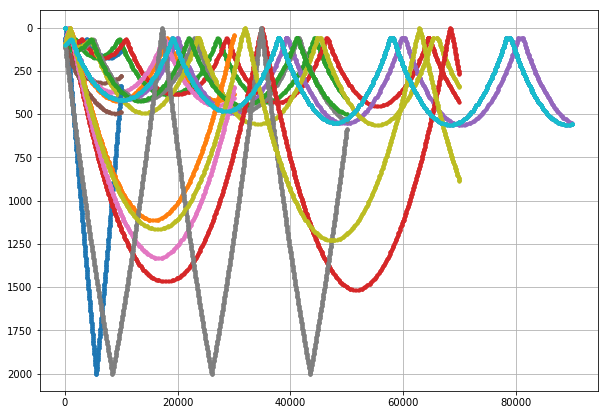

In [618]:
plt.figure(figsize=(10,7))
for i in range (list_R.shape[0]) : 
    plt.plot (list_R[i,:], list_Z[i,:],'.')

plt.gca().invert_yaxis()
plt.grid()


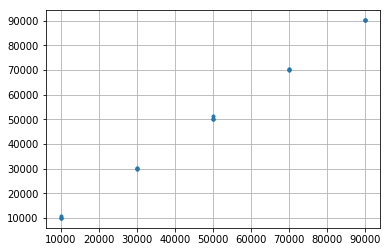

In [551]:
plt.plot(REAL_RANGE, Dist, '.')
#plt.xlim([49000.,51000.])
#plt.ylim([50050.,50070.])
plt.grid()


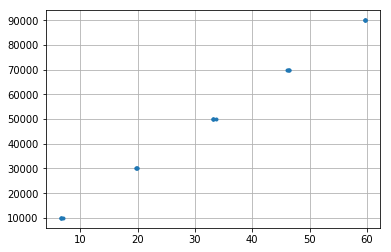

In [552]:
plt.plot(TT, REAL_RANGE, '.')
#plt.xlim([49000.,51000.])
#plt.ylim([50050.,50070.])
plt.grid()


In [557]:
REAL_RANGE

array([10000., 30000., 50000., 70000., 90000., 10000., 30000., 50000.,
       70000., 90000., 10000., 30000., 50000., 70000., 90000., 10000.,
       30000., 50000., 70000., 90000.])

In [624]:
PROF = np.zeros(D.size*R.size)
for k in range (D.size) :
    PROF[k*R.size:(k+1)*R.size] = D[k]

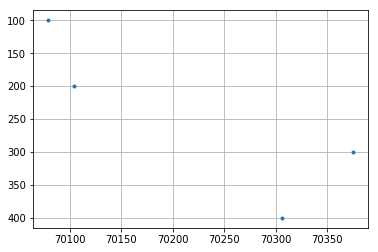

In [637]:
# real range = 70km
plt.plot(Dist[3::5], PROF[3::5], '.')
plt.gca().invert_yaxis()
plt.grid()

In [ ]:
### Pas de relation linéaire entre distance parcourue et profondeur (à un range fixé)...

---
----
---

## Idées ...

In [ ]:
# écrire les .env
# executer bellhop
# lire les .arr et tracer les 20 (ou plus) vignettes

# trouver la tendance
# définir des zones
# faire des stats 


# trajectoire effectuée par le rayon (lancer eigenrays E, puis calcul de la distance)
# quelle erreur si trajectoire approximée à une trajectoire directe par exemple ? 

In [ ]:
## conclusion : y a-t-il des méthodes de détection privilégiées ? 

In [ ]:
# Quelle erreur si mauvaise détection ? 
# Quelle conséquence si paquet et pas rayon isolé ? 
# 